# Uplift Modeling

In [4]:
# -*- coding:utf-8 -*-
import random
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

In [1]:
def generate_sample_data(num: int, seed: int=1) -> list:
    '''
    @param num: 標本サイズ
    @param seed: ランダムシード
    @return is_cv_list: コンバージョンしたか否か
    @return is_treat_list: 実験群か否か
    @return feature_vector_list: 8次元の特徴量
    '''
    # 返すリストを確保
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []

    # 乱数を初期化
    random_instance = random.Random(seed)

    # 返す関数の特徴を設定
    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]  # 統制群が持つ重み
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]  # 介入により変化する重み

    for i in range(num):
        # 特徴ベクトルを乱数で生成
        feature_vector = [random_instance.random() for _ in range(feature_num)]
        # 実験群かどうかを乱数で決定
        is_treat = random_instance.choice((True, False))
        # 内部的なコンバージョンレートを算出
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])

        # 実験群であれば、lift_weightを加味する
        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
        
        # 実際にコンバージョンしたかどうかを決定する
        is_cv = cv_rate > random_instance.random()

        # 生成した値を格納
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
    
    return is_cv_list, is_treat_list, feature_vector_list

### 学習用のサンプルデータを生成し、全体のコンバージョンレートを確認する

In [5]:
# trainデータの生成
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# データをtreatmentとcontrolに分離
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []
for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

# コンバージョンレートを表示
print('treatment_cvr', treat_is_cv_list.count(True) / len(treat_is_cv_list))
print('control_cvr', control_is_cv_list.count(True) / len(control_is_cv_list))


'''学習器を構築して、trainデータの学習を行う'''
# 学習器の生成
treat_model = LogisticRegression(C=0.01, solver='liblinear')
control_model = LogisticRegression(C=0.01, solver='liblinear')

# 学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

# seedを変えて、テストデータを生成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# それぞれの学習器でコンバージョンレートを予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# スコアの算出、スコア：実験群の予測CVR / 統制群の予測CVR
# predict_probaはクラス所属確率のリストを返すため、1番目を参照する
# numpy.ndarrayなので、そのまま割り算しても、要素の割り算になる
score_list = treat_score[:, 1] / control_score[:, 1]

treatment_cvr 0.031220247540463344
control_cvr 0.031905453372055505


### スコアの大きい順にソートして、10パーセンタイルごとにCVRを算出して比較

Text(0, 0.5, 'conversion rate')

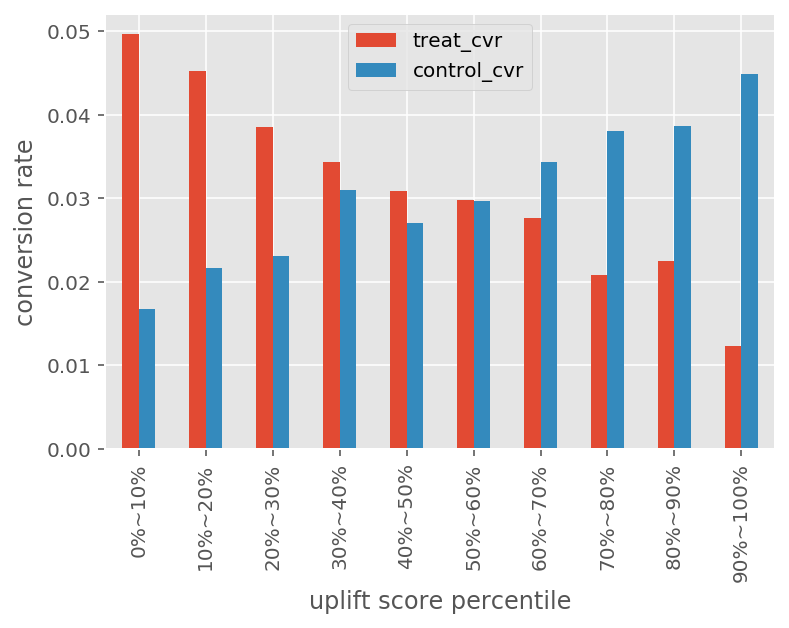

In [8]:
# スコアが高い順に並び替える
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 結果を10%ごとに切断
    start = int(n * len(result) / 10)
    end = int((n+1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # 実験群と統制群の数を数える
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    # 実験群と統制群のコンバージョン数を計測
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    # コンバージョンレートに変換し、表示用にDataFrameに格納
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel('uplift score percentile')
plt.ylabel('conversion rate')

### Uplift Modelingの評価 AUUC

Text(0, 0.5, 'conversion lift')

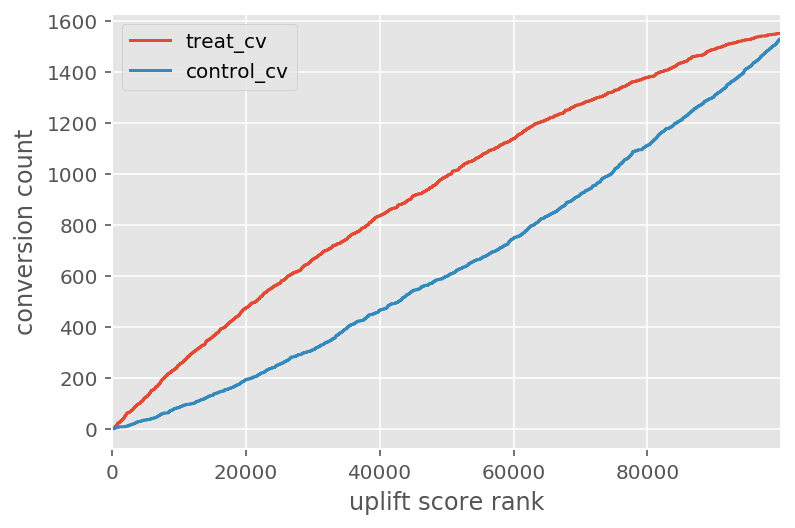

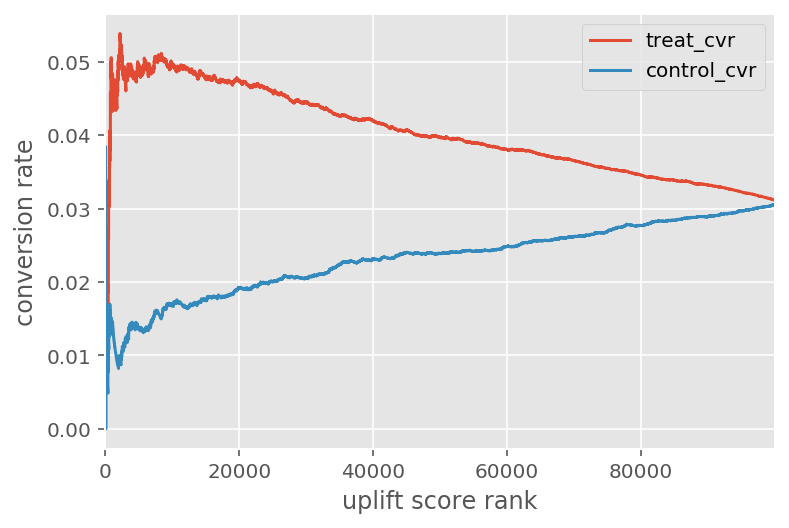

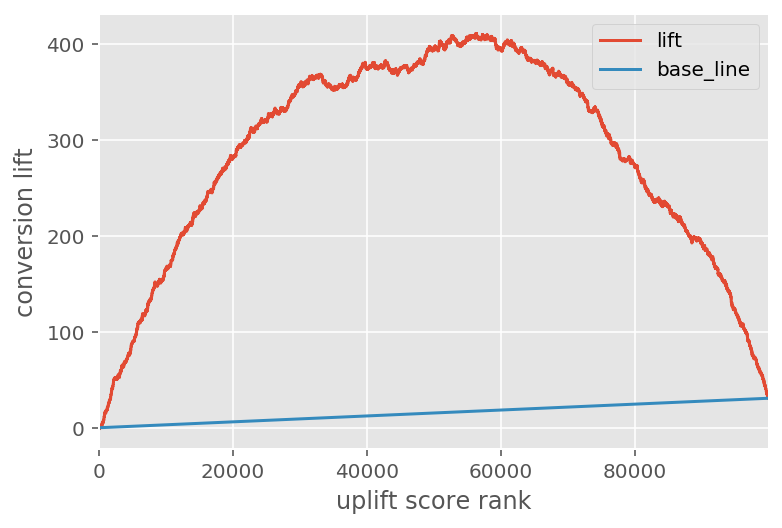

In [10]:
# スコア順に集計を行う
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    
    # コンバージョンレートの差に実験群の人数を掛けることでliftを算出
    # CVRの差なので、実験群と統制群の大きさが異なっていても算出可能
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])
    
# 統計データを、DataFrameに変換する
df = pd.DataFrame(stat_data)
df.columns = ['is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu', 'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift']

# ベースラインを書き加える
df['base_line'] = df.index * df['lift'][len(df.index)-1] / len(df.index)

# 可視化する
df.plot(y=['treat_cv', 'control_cv'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion count')

df.plot(y=['treat_cvr', 'control_cvr'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion rate')

df.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')

In [11]:
auuc = (df['lift'] - df['base_line']).sum() / len(df['lift'])
print('AUUC', auuc)

AUUC 267.2627260920977


Text(0, 0.5, 'conversion lift')

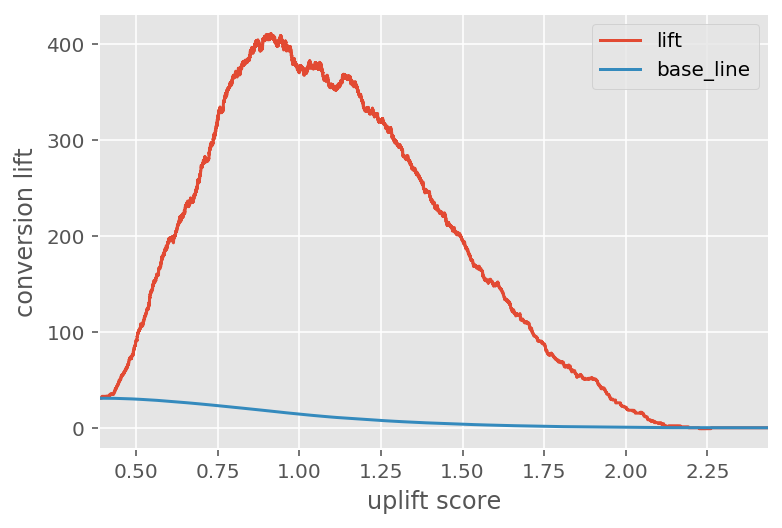

In [12]:
# 横軸をスコアにしたliftのグラフを可視化する
df.plot(x='score', y=['lift', 'base_line'])
plt.xlabel('uplift score')
plt.ylabel('conversion lift')